In [11]:
# Import dependencies
import time
import numpy as np
import matplotlib.pyplot as plt

Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

The Risk-neutral Expectation Pricing Formula in Continuous Time is given by:
$$\frac{C_t}{B_t} = \mathbb{E_Q}[\frac{C_{T}}{B_T} | {F}_{t}]$$


In this scenario, we assume a constant interest rate, and as a result, the discount factor is given by $\exp(-rT)$. The stock's dynamics are modeled using Geometric Brownian Motion (GBM) with the following equation:

$
dS_t = rS_t dt + \sigma S_t dW_t
$

In terms of the stock price $S$, we can express the solution under risk-neutral dynamics as:

$
S_{t + \Delta t} = S_t \exp{(\nu \Delta t + \sigma \sqrt{\epsilon}i)}
$

Where $\nu = r - \frac{1}{2}\sigma^2$.


When it comes to valuing intricate or unconventional options that depend on the path of the underlying asset, one commonly used product is the barrier option. These options follow the standard European expiration style, but they either become invalid or become active only when the underlying asset's price crosses a predetermined barrier level.

The barrier level can be monitored either continuously or discretely over time, denoted as $\tau$.

For an up-and-out barrier put option, the option's value at time $T$, denoted as $C_T$ and defined as $f(S_T)$, can be expressed as:

$
C_T = (K - S_T)^+ Ind (\max\limits_{t \in \tau} S_t < H)
$

In other words, for all simulations $m \in M$:

- If $t \in \tau$ and $S_t \geq H$, then $C_T = 0$.
- Otherwise, if $t \notin \tau$ or $S_t < H$, then $C_T = (K - S_T)^+$
$


In [12]:
# Initialise parameters
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
H = 125       # up-and-out barrier price/value
r = 0.01      # annual risk-free rate
vol = 0.2     # volatility (%)

N = 100       # number of time steps
M = 1000      # number of simulations

In this context, we directly generate simulations for the stock price, denoted as $S_t$, because we need this specific value in the calculations for comparing it to the barrier level $H$

In [13]:
start_time = time.time()

# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    
    # Barrier Crossed Flag
    BARRIER = False
    St = S0
    
    for j in range(N):
        epsilon = np.random.normal()
        Stn = St*np.exp( nudt + volsdt*epsilon )
        St = Stn
        if St >= H:
            BARRIER = True
            break
            
    if BARRIER:
        CT = 0
    else:
        CT = max(0, K - St)
        
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Call value is $7.52 with SE +/- 0.326
Computation time is:  0.7238


The np.any() function is used to determine whether there is at least one True element in the ndarray provided as the first parameter. It returns True if there is at least one True element, and False if all elements are False.

In [14]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )

# Copy numpy array for plotting
S = np.copy(ST)

# Apply Barrier Condition to ST numpy array
mask = np.any(ST >= H, axis=0)
ST[:,mask] = 0

CT = np.maximum(0, K - ST[-1][ST[-1] != 0])
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Call value is $7.8 with SE +/- 0.332
Computation time is:  0.0099


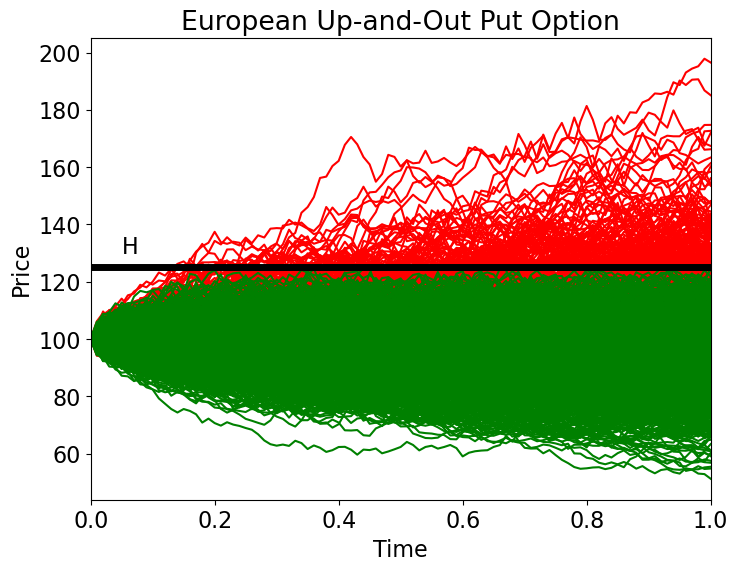

In [15]:
plt.figure(figsize=(8,6))

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = "16"

plt.plot(np.linspace(0,T,N+1),S[:,mask],'r')
plt.plot(np.linspace(0,T,N+1),S[:,~mask],'g')
plt.plot([0,T],[H,H], 'k-',linewidth=5.0)
plt.annotate('H', (0.05,130))
plt.xlim(0,1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('European Up-and-Out Put Option')

plt.show()